<a href="https://colab.research.google.com/github/harryypham/MyMLPractice/blob/main/ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.utils as utils
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

%matplotlib inline

In [23]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
num_classes = 10
epochs = 5
learning_rate = 0.01
resnet_ver = "resnet50"
batch_size = 64

def load_transform_32():
  train_transforms = transforms.Compose([
      transforms.RandomCrop(32, padding=4),
      transforms.RandomHorizontalFlip(),
      transforms.ToTensor(),
      # transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
      transforms.Normalize((0.5),(0.5))
  ])

  test_transforms = transforms.Compose([
      transforms.Resize((32, 32)),
      transforms.ToTensor(),
      transforms.Normalize((0.5),(0.5))
      # transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
  ])
  return train_transforms, test_transforms

def load_transform_224():
  train_transforms = transforms.Compose([
      transforms.Resize((224, 224)),
      transforms.RandomHorizontalFlip(),
      transforms.ToTensor(),
      transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
  ])
  test_transforms = transforms.Compose([
      transforms.Resize((224, 224)),
      transforms.ToTensor(),
      transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
  ])
  return train_transforms, test_transforms

train_transforms, test_transforms = load_transform_32()

def load_cifar10():
  train_set = torchvision.datasets.CIFAR10("/content/data", train=True, download=True, transform=train_transforms)
  valid_set = torchvision.datasets.CIFAR10("/content/data", train=True, transform=test_transforms)
  test_set = torchvision.datasets.CIFAR10("/content/data", train=False, download=True, transform=test_transforms)
  return train_set, valid_set, test_set

def load_minst():
  train_set = torchvision.datasets.MNIST("/content/data", train=True, download=True, transform=train_transforms)
  valid_set = torchvision.datasets.MNIST("/content/data", train=True, transform=test_transforms)
  test_set = torchvision.datasets.MNIST("/content/data", train=False, download=True, transform=test_transforms)
  return train_set, valid_set, test_set

train_set, valid_set, test_set = load_minst()

def load_datasets(train_set, valid_set, test_set, split_frac=0.1):
  train_indices, valid_indices = train_test_split(list(range(len(train_set))), test_size=split_frac)

  train_set = utils.data.Subset(train_set, train_indices)
  valid_set = utils.data.Subset(valid_set, valid_indices)

  trainloader = DataLoader(train_set, batch_size=batch_size)
  validloader = DataLoader(valid_set, batch_size=batch_size)
  testloader = DataLoader(test_set, batch_size=batch_size, num_workers=2)

  return trainloader, validloader, testloader

trainloader, validloader, testloader = load_datasets(train_set, valid_set, test_set)


In [11]:
class Block(nn.Module):
  expansion = 1
  def __init__(self, in_channels, out_channels, stride=1, skip_connection=None):
    super().__init__()
    self.conv1 = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU()
    )
    self.conv2 = nn.Sequential(
        nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_channels),
    )
    self.skip_connection = skip_connection

  def forward(self, x):
    skip_x = x.clone()
    out = self.conv1(x)
    out = self.conv2(out)
    if self.skip_connection is not None:
      skip_x = self.skip_connection(skip_x)
    out += skip_x
    return F.relu(out)

class Bottleneck(nn.Module):
  expansion = 4
  def __init__(self, in_channels, out_channels, stride=1, skip_connection=None):
    super().__init__()
    self.conv1 = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(),
    )
    self.conv2 = nn.Sequential(
        nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(),
    )
    self.conv3 = nn.Sequential(
        nn.Conv2d(out_channels, out_channels*4, kernel_size=1, stride=1, padding=0),
        nn.BatchNorm2d(out_channels*4),
    )
    self.skip_connection = skip_connection


  def forward(self, x):
    skip_x = x.clone()
    out = self.conv1(x)
    out = self.conv2(out)
    out = self.conv3(out)
    if self.skip_connection is not None:
      skip_x = self.skip_connection(x)
    out += skip_x
    return F.relu(out)



class ResNet(nn.Module):
  def __init__(self, block, layers, num_classes):
    super(ResNet, self).__init__()
    self.in_channels = 64
    self.layer1 = nn.Sequential(
        nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
    )

    self.layer2 = self._make_layer(block, layers[0], 64, 64, 1)
    self.layer3 = self._make_layer(block, layers[1], 64*block.expansion, 128, 2)
    self.layer4 = self._make_layer(block, layers[2], 128*block.expansion, 256, 2)
    self.layer5 = self._make_layer(block, layers[3], 256*block.expansion, 512, 2)
    self.avgpool = nn.AvgPool2d(7, stride=1)
    self.fc = nn.Linear(512*4, num_classes)


  def _make_layer(self, ResBlock, num_blocks, in_channels, out_channels, stride=1):
    skip_connection = None
    if stride != 1 or in_channels != out_channels*ResBlock.expansion:
      skip_connection = nn.Sequential(
          nn.Conv2d(in_channels, out_channels*ResBlock.expansion, kernel_size=1, stride=stride),
          nn.BatchNorm2d(out_channels*ResBlock.expansion)
      )
    layers = []
    layers.append(ResBlock(in_channels, out_channels, stride, skip_connection))
    in_channels = out_channels*ResBlock.expansion
    for i in range(num_blocks-1):
      layers.append(ResBlock(in_channels, out_channels))

    return nn.Sequential(*layers)


  def forward(self, x):
    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = self.layer4(x)
    x = self.layer5(x)

    x = self.avgpool(x)
    x = x.view(x.size(0), -1)
    x = self.fc(x)

    return x




class SimpleResNet(nn.Module):
  def __init__(self, block, layers, chans, num_classes):
    super(SimpleResNet, self).__init__()
    self.layer1 = nn.Sequential(
        nn.Conv2d(chans, 16, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(16),
        nn.ReLU()
    )

    self.layer2 = self._make_layer(block, layers[0], 16, 16, 1)
    self.layer3 = self._make_layer(block, layers[1], 16, 32, 2)
    self.layer4 = self._make_layer(block, layers[2], 32, 64, 2)
    self.layer5 = self._make_layer(block, layers[3], 64, 128, 2)
    self.avgpool = nn.AvgPool2d(3, stride=1, padding=1)
    self.fc = nn.Linear(128*4*4, num_classes)


  def _make_layer(self, ResBlock, num_blocks, in_channels, out_channels, stride=1):
    skip_connection = None
    if stride != 1 or in_channels != out_channels*ResBlock.expansion:
      skip_connection = nn.Sequential(
          nn.Conv2d(in_channels, out_channels*ResBlock.expansion, kernel_size=1, stride=stride),
          nn.BatchNorm2d(out_channels*ResBlock.expansion)
      )
    layers = []
    layers.append(ResBlock(in_channels, out_channels, stride, skip_connection))
    in_channels = out_channels*ResBlock.expansion
    for i in range(num_blocks-1):
      layers.append(ResBlock(in_channels, out_channels))

    return nn.Sequential(*layers)


  def forward(self, x):
    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = self.layer4(x)
    x = self.layer5(x)

    x = self.avgpool(x)
    x = x.view(x.size(0), -1)
    x = self.fc(x)

    return x


In [4]:
def compute_accuracy(dataloader, model, device):
  model.to(device)
  model.eval()
  with torch.set_grad_enabled(False):
    correct = 0
    total = 0
    for inputs, targets in dataloader:
      inputs = inputs.to(device)
      targets = targets.to(device)
      outputs = model(inputs)
      _, predict = torch.max(outputs, 1)
      correct += predict.eq(targets).sum().item()
      total += targets.shape[0]

    return correct/total * 100


In [ ]:
match resnet_ver:
  case "resnet18":
    block = Block
    layers = [2, 2, 2, 2]
  case "resnet34":
    block = Block
    layers = [3, 4, 6, 3]
  case "resnet50":
    block = Bottleneck
    layers = [3, 4, 6, 3]
  case "resnet101":
    block = Bottleneck
    layers = [3, 4, 23, 3]
  case "resnet152":
    block = Bottleneck
    layers = [3, 8, 36, 3]

model = ResNet(block, layers, 10).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optims = ["SGD",  "Adam"]
loss_history = {}


for optim in optims:
  print(f'Training with {optim}')
  if optim == "SGD":
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay = 1e-4, momentum = 0.9)
    lr_sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.01, epochs=epochs, steps_per_epoch=len(trainloader))
  elif optim == "Adam":
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-8, weight_decay=1e-4)
    lr_sched = None
  loss_arr = []
  for epoch in range(epochs):
    print(f'\nEpoch {epoch+1}:')
    train_loss = 0
    correct = 0
    total = 0

    for i, (inputs, labels) in enumerate(trainloader):
      model.train()
      inputs, labels = inputs.to(device), labels.to(device)
      optimizer.zero_grad()
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
      if lr_sched:
        lr_sched.step()

      train_loss += loss.item()
      _, predict = outputs.max(1)
      total += labels.size(0)
      correct += predict.eq(labels).sum().item()

      if (not i % 100) and i != 0:
            print ('Batch %03d | Cost: %.6f | Train Acc: %.4f'
                  %(i, train_loss/(i+1), 100*correct/total))

    loss_arr.append(train_loss/total)
    print("Valid Acc: %.3f" % compute_accuracy(validloader, model, device))
  loss_history[optim] = loss_arr

Training with SGD

Epoch 1:
Batch 100 | Cost: 2.238155 | Train Acc: 16.3676
Batch 200 | Cost: 2.104293 | Train Acc: 21.9216
Batch 300 | Cost: 2.012722 | Train Acc: 25.0831
Batch 400 | Cost: 1.935958 | Train Acc: 27.9419
Batch 500 | Cost: 1.872578 | Train Acc: 30.3986
Batch 600 | Cost: 1.825013 | Train Acc: 32.2015
Batch 700 | Cost: 1.787548 | Train Acc: 33.7531
Valid Acc: 45.100

Epoch 2:
Batch 100 | Cost: 1.512947 | Train Acc: 45.1733
Batch 200 | Cost: 1.530274 | Train Acc: 45.0326
Batch 300 | Cost: 1.518096 | Train Acc: 46.0652
Batch 400 | Cost: 1.490415 | Train Acc: 47.5140
Batch 500 | Cost: 1.455973 | Train Acc: 48.6589
Batch 600 | Cost: 1.435152 | Train Acc: 49.3266
Batch 700 | Cost: 1.415728 | Train Acc: 50.2051
Valid Acc: 57.560

Epoch 3:
Batch 100 | Cost: 1.183962 | Train Acc: 58.9728
Batch 200 | Cost: 1.190355 | Train Acc: 59.0019
Batch 300 | Cost: 1.162224 | Train Acc: 60.0083
Batch 400 | Cost: 1.145909 | Train Acc: 60.7622
Batch 500 | Cost: 1.120594 | Train Acc: 61.5706
Batc

Text(0, 0.5, 'Training loss')

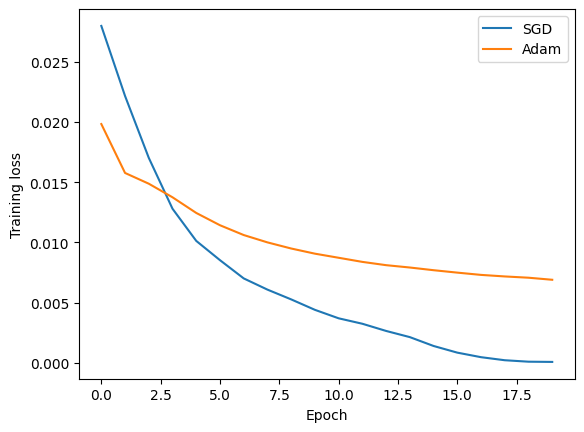

In [ ]:
plt.figure()
x = np.arange(0, epochs, 1)
for k,v in loss_history.items():
  plt.plot(x, v, label=k)
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Training loss")

In [24]:
model = SimpleResNet(Block, [2, 2, 2, 2], 1, 10)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.01, epochs=epochs, steps_per_epoch=len(trainloader))
print(model)

SimpleResNet(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer2): Sequential(
    (0): Block(
      (conv1): Sequential(
        (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (conv2): Sequential(
        (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): Block(
      (conv1): Sequential(
        (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (conv2): Sequential(
        (0): Conv2d(16, 16, k

In [25]:

for epoch in range(epochs):
    print(f'\nEpoch {epoch+1}:')
    train_loss = 0
    correct = 0
    total = 0

    for i, (inputs, labels) in enumerate(trainloader):
      model.train()

      # if (epoch in [12, 15]  and i == 0):
      #     optimizer.param_groups[0]['lr'] /= 10
      #     print("Learning rate adjust...")


      inputs, labels = inputs.to(device), labels.to(device)
      optimizer.zero_grad()
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
      sched.step()

      train_loss += loss.item()
      _, predict = outputs.max(1)
      total += labels.size(0)
      correct += predict.eq(labels).sum().item()

      if (not i % 100) and i != 0:
            print ('Batch %03d | Cost: %.6f | Train Acc: %.4f'
                  %(i, train_loss/(i+1), 100*correct/total))

    print("Valid Acc: %.3f" % compute_accuracy(validloader, model, device))


Epoch 1:
Batch 100 | Cost: 1.893276 | Train Acc: 31.3892
Batch 200 | Cost: 1.415641 | Train Acc: 50.4897
Batch 300 | Cost: 1.113880 | Train Acc: 61.4047
Batch 400 | Cost: 0.922758 | Train Acc: 68.1227
Batch 500 | Cost: 0.790927 | Train Acc: 72.7794
Batch 600 | Cost: 0.696862 | Train Acc: 76.1179
Batch 700 | Cost: 0.624416 | Train Acc: 78.7134
Batch 800 | Cost: 0.566609 | Train Acc: 80.7428
Valid Acc: 90.933

Epoch 2:
Batch 100 | Cost: 0.141947 | Train Acc: 95.4208
Batch 200 | Cost: 0.150786 | Train Acc: 95.2659
Batch 300 | Cost: 0.140981 | Train Acc: 95.6447
Batch 400 | Cost: 0.134663 | Train Acc: 95.8346
Batch 500 | Cost: 0.131393 | Train Acc: 95.9331
Batch 600 | Cost: 0.124936 | Train Acc: 96.1106
Batch 700 | Cost: 0.120296 | Train Acc: 96.2286
Batch 800 | Cost: 0.116367 | Train Acc: 96.3678
Valid Acc: 90.167

Epoch 3:
Batch 100 | Cost: 0.079811 | Train Acc: 97.2927
Batch 200 | Cost: 0.086447 | Train Acc: 97.1626
Batch 300 | Cost: 0.083475 | Train Acc: 97.3578
Batch 400 | Cost: 0.08

In [26]:
print("Test accuracy: %.2f" % compute_accuracy(testloader, model, device))
torch.cuda.empty_cache()

Test accuracy: 98.73
